Projeto de predição de grau de estado deterioração do figado devido ao HCV

Equipe: Daniel Lemos,
        Rafael Targino
        
Data_Set: https://archive.ics.uci.edu/ml/machine-learning-databases/00503/HCV-Egy-Data.zip


Passos:
Ler os dados e normalizá-los cross-validation 10 folds
Utilizar os seguintes algoritimos:
1- KNN variando o K(1,3,5,10)
2- Naive-Bayes
3- Arvore de Decisão (Random Forrest) variando o numero de florestas
4- RLScore(variando o numero de kernels)

In [1]:
!pip install rlscore
import numpy as np
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

     |████████████████████████████████| 788kB 5.0MB/s 
  Created wheel for rlscore: filename=rlscore-0.8.1-cp36-cp36m-linux_x86_64.whl size=1824820 sha256=866f1aa6c52f91f775baaf4a10341863461601b692e08d58946532af9c462ee1
  Stored in directory: /root/.cache/pip/wheels/96/d7/27/cd7b2182c3f5c012dbbf9a8507116b9c49140ffc733223c07b
Successfully built rlscore


Base de dados de pacientes egípcios que foram submetidos a doses de tratamento para HCV cerca de 18 meses. A discretização deve ser aplicada com base em recomendações de especialistas; há um arquivo anexado mostra como.

A base de dados reúne cerca de 

Os dados apresentão o estágio inicial da entrada dos pacientes e as taxas , o problema é diagnosticar o grau de degradação do fígado através dos exames previamente levantados, sem a necessidade de exame de ultrasom ou histológico, ou seja prever o resultado do exame histológio acelerando assim que tipo de tratamento aplicar.
as classes são não fibroso que significa saldável, fibroso, fibroso com poucas cepas do vírus, fibroso com muitas cepas e cirrose.


AxesSubplot(0.125,0.125;0.775x0.755)
      Age   Gender  ...  Baseline histological Grading  Baselinehistological staging
0     56.0     1.0  ...                           13.0                           2.0
1     46.0     1.0  ...                            4.0                           2.0
2     57.0     1.0  ...                            4.0                           4.0
3     49.0     2.0  ...                           10.0                           3.0
4     59.0     1.0  ...                           11.0                           1.0
...    ...     ...  ...                            ...                           ...
1323  59.0     1.0  ...                           16.0                           2.0
1324  46.0     1.0  ...                           11.0                           2.0
1325  52.0     2.0  ...                           16.0                           2.0
1326  55.0     1.0  ...                           10.0                           2.0
1327  42.0     1.0  ...     

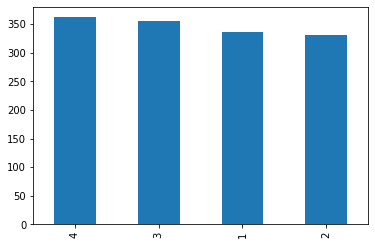

In [8]:
df = pd.read_csv("https://drive.google.com/uc?authuser=0&id=1S2HnHU5zoI7ERYhVd8naSaUMt0eJZW3L&export=download")

columns = df.columns


ax = df['Baselinehistological staging'].value_counts().plot.bar()
print(ax)
classes = df['Baselinehistological staging'].unique()

index_amostra= list()
index_1 = 0
index_3 = 0
index_4 = 0
index_2 = 0
for x in df.index:
  if index_2<332:
    if df.loc[x,'Baselinehistological staging'] == 2:
      index_amostra.append(x)
      index_2= index_2+1
  if index_4<332:    
    if df.loc[x,'Baselinehistological staging'] == 4:
      index_amostra.append(x)
      index_4 = index_4 +1
  if index_3<332:
    if df.loc[x,'Baselinehistological staging'] == 3:
      index_amostra.append(x)
      index_3 = index_3 +1
  if index_1<332:
    if df.loc[x,'Baselinehistological staging'] ==1:
      index_amostra.append(x)
      index_1 = index_1 +1
dfAvalues = []
for g in index_amostra:
  dfAvalues.append(df.iloc[g].values)

dfAmostra = pd.DataFrame(dfAvalues,columns=columns)
print(dfAmostra)


Preparação dos dados de três formas diferentes, sendo escalados entre 0 e 1, valores absolutos  e normalizados, gerando três dataframes diferentes para os testes, separação das labels do Features.

AxesSubplot(0.125,0.125;0.775x0.755)


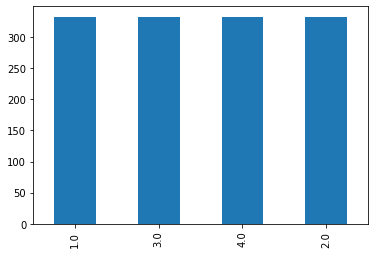

In [69]:
from sklearn import preprocessing
dfclass = pd.Series(dfAmostra['Baselinehistological staging'])
dfsclass = pd.DataFrame(dfAmostra.iloc[:,0:28]) 

columns = dfsclass.columns
ax = dfclass.value_counts().plot.bar()
print(ax)

repcolumns = list()
for index, column in enumerate(columns):
  column = column.replace(" ","")
  repcolumns.append(column)
x = dfsclass.values
x_scale = preprocessing.scale(dfsclass)
x_normal = preprocessing.normalize(dfsclass, norm='l1')
min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(dfsclass)
x_abs = max_abs_scaler.fit_transform(dfsclass)


dfnorm = pd.DataFrame(x_normal, columns = repcolumns)
df_abs = pd.DataFrame(x_abs, columns = repcolumns)
df_scale = pd.DataFrame(x_scaled, columns = repcolumns)

dfL = {'Normalizado': dfnorm,'Valor_Absoluto': df_abs,'Escalado': df_scale}




Geração dos kfolds

In [0]:

def TesteNB(self,X_train,X_test,y_train,y_test,dfL,dl):
  from sklearn.model_selection import cross_val_score
  Result_cross_valG ={}
  Result_cross_valM ={}
  Result_AcG = {}
  Result_AcM = {}

  gnb = GaussianNB()
  gnb.fit(X_train, y_train)
  y_pred = gnb.predict(X_test)
  acu = metrics.accuracy_score(y_test, y_pred)
  Result_cross_valG[dl]=cross_val_score(gnb,dfL[dl],dfclass,cv=10)
  if dl in Result_Ac:
    if Result_Ac[dl]<acu:
      Result_Ac[dl] = acu
    else:
      Result_Ac[dl] = acu

  gnb = MultinomialNB()
  gnb.fit(X_train, y_train)
  y_pred = gnb.predict(X_test)
      
  Result_cross_in_NBG = {}
  Result_acu_NB = {}
  Result_cross_in_NBG[dl] = max(Result_cross_val[dl])
  print(Result_cross_in_NB)
  print(Result_Ac)



In [79]:
#from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from rlscore.learner import LeaveOneOutRLS
from rlscore.measure import ova_accuracy
from rlscore.utilities.multiclass import to_one_vs_all
from sklearn import metrics

from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=10,shuffle=True)

X_index = dfnorm.index
Y_index = dfclass.index
Resultados = list()
Resultado_Gau = list()
estimators =[100,200,500,800]
neighbors = [1,3,5,10]

for dl in dfL:
 
  TesteNB(X_train,X_test,y_train,y_test,dfL,dl)
'''for dl in dfL:
  for Features, Labels in skf.split(dfL[dl],dfclass):
    X_train, X_test = dfL[dl].iloc[Features], dfL[dl].iloc[Labels]
    y_train, y_test = dfclass.iloc[Features], dfclass.iloc[Labels]

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    acu = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy GaussianNB: {}'.format(acu))

    gnb = MultinomialNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    print('Accuracy MultinominalNB: {}'.format(metrics.accuracy_score(y_test, y_pred)))

    for n in estimators:
      rf = RandomForestClassifier(n_estimators=n)
      rf.fit(X_train,y_train)
      predictions = rf.predict(X_test)
      print('Accuracy com estimator {} : {}'.format(n,metrics.accuracy_score(y_test, predictions)))


    y_train = to_one_vs_all(y_train, False)
    y_test = to_one_vs_all(y_test, False)
    regparams = [2.**i for i in range(-15, 16)]
    learner = LeaveOneOutRLS(X_train, y_train, regparams=regparams, measure=ova_accuracy)
    P_test = learner.predict(X_test)
      
    print("test set accuracy {}".format(ova_accuracy(y_test, P_test)) )

    
  
    y_train = to_one_vs_all(y_train, False)
    y_test = to_one_vs_all(y_test, False)
    regparams = [2.**i for i in range(-15, 16)]
    learner = LeaveOneOutRLS(X_train, y_train, regparams=regparams, measure=ova_accuracy)
    P_test = learner.predict(X_test)
      
    print("test set accuracy {}".format(ova_accuracy(y_test, P_test)) )

    for n in neighbors:
      
      neigh = KNeighborsClassifier(n_neighbors=n)
      neigh.fit(X_train, y_train)
      y_predic = neigh.predict(X_test,y_test)
  '''


TypeError: ignored

In [0]:
from rlscore.learner import LeaveOneOutRLS
from rlscore.measure import ova_accuracy
from rlscore.utilities.multiclass import to_one_vs_all

import numpy as np





def train_rls():
   
    for Features, Labels in skf.split(dl,dfclass):
      X_train, X_test = dfsclass.iloc[Features], dfsclass.iloc[Labels]
      y_train, y_test = dfclass.iloc[Features], dfclass.iloc[Labels]
      y_train = to_one_vs_all(y_train, False)
      y_test = to_one_vs_all(y_test, False)
      regparams = [2.**i for i in range(-15, 16)]
      learner = LeaveOneOutRLS(X_train, y_train, regparams=regparams, measure=ova_accuracy)
      P_test = learner.predict(X_test)
      
      print("test set accuracy {}".format(ova_accuracy(y_test, P_test)) )

train_rls()

/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):
/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):


test set accuracy 0.2727272727272727
test set accuracy 0.23484848484848486
test set accuracy 0.2803030303030303
test set accuracy 0.25757575757575757
test set accuracy 0.29545454545454547
test set accuracy 0.19696969696969696
test set accuracy 0.25757575757575757
test set accuracy 0.2196969696969697
test set accuracy 0.2196969696969697
test set accuracy 0.29545454545454547


Naive-Bayes

Random Forrest

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

estimators =[100,200,500,800]

for df in dfL:
  for n in estimators:
    train_features, test_features, train_labels, test_labels = train_test_split(df, dfclass, test_size = 0.25, random_state = 42)
    rf = RandomForestClassifier(n_estimators=n)

    rf.fit(train_features,train_labels)
    predictions = rf.predict(test_features)
    print('Accuracy com estimator {} : {}'.format(n,metrics.accuracy_score(test_labels, predictions)))
  

Accuracy com estimator 100 : 0.29394812680115273
Accuracy com estimator 200 : 0.29394812680115273
Accuracy com estimator 500 : 0.2824207492795389
Accuracy com estimator 800 : 0.3285302593659942
Accuracy com estimator 100 : 0.24495677233429394
Accuracy com estimator 200 : 0.2478386167146974
Accuracy com estimator 500 : 0.26512968299711814
Accuracy com estimator 800 : 0.24495677233429394
Accuracy com estimator 100 : 0.25936599423631124
Accuracy com estimator 200 : 0.2737752161383285
Accuracy com estimator 500 : 0.2478386167146974
Accuracy com estimator 800 : 0.2737752161383285


KNN

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

neighbors = [1,3,5,10]

for df in dfL:
  for n in neighbors:
    train_features, test_features, train_labels, test_labels = train_test_split(df, dfclass, test_size = 0.25, random_state = 42)
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(train_features, train_labels)
    y_predic = neigh.predict(test_features)
    acc = accuracy_score(test_labels,y_predic)    
    print(acc)



0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.24096385542168675
0.24096385542168675
0.24096385542168675
0.24096385542168675
